# Connecting the Pieces Together: A Data Mining Initiative on a Lego Database with SQL

Data Collected by Rachel Tatman  
Data Source from Rebrickable  
Uploaded on Kaggle  
Link: https://www.kaggle.com/datasets/rtatman/lego-database

### Here is the database schema provided by Ms. Tatman for the Lego Database

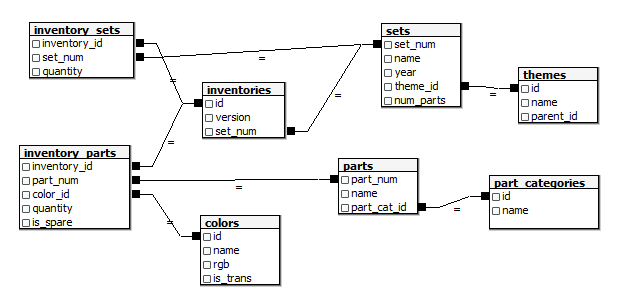

### Initial Observations with the Lego Database
1. There is a table "sets" that describes a product's number of Lego parts, theme, and year of release.
2. Connected to the "sets" table is the "themes" table which houses the Lego category each product is registered to.
3. The table "inventory_parts" is connected to the "sets" and "themes" table. "inventory_parts" is also connected with the tables that point out to the colors and categories of the individual bricks.

### Objectives for the Data Analysis
#### Given the database schema and available data, here are the questions that can be answered:
1. Are the number of individual Lego pieces per product increasing throughout the years? What about in a per theme basis?
2. What are the most popular themes for Lego and have they changed throughout the recent years? Are there new themes recently that Lego seems to focus on?
3. Have the color preferences for Lego bricks changed through the years?

### Data Analysis for the Lego Database

In [1]:
# Import duckdb and pandas
import duckdb
import pandas as pd

# Enable magic commands to enable the following settings for this analysis
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect to the 'lego.db' on duckdb
%sql duckdb:///lego.db

#### Analyze the themes table first and inspect the format


In [2]:
%%sql
SELECT *
FROM themes
LIMIT 30;

,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0
5,6,Airport,5.0
6,7,Construction,5.0
7,8,Farm,5.0
8,9,Fire,5.0
9,10,Harbor,5.0


It appears that each main theme has sub-themes. For this analysis, the focus will be on the main themes as the analysis objective involves the entire Lego environment.

In [3]:
%%sql
SELECT *
FROM themes AS t1
LEFT JOIN themes AS t2 ON
t1.id = t2.parent_id
LEFT JOIN themes AS t3 ON
t2.id = t3.parent_id
LEFT JOIN themes AS t4 ON
t3.id = t4.parent_id
WHERE t4.name NOT NULL;

""


From the SQL query above, it appears that there are three layers of themes for the "themes" table. For the sake of this analysis, all of the sub-themes will be housed inside the main theme as the label for the table. In other words, the rows with the name of the sub-themes will be replaced with the name of the main theme instead.

Doing this will reduce the number of themes to be analyzed and condense the analysis to the main themes. This step will be done on the next SQL query.

In [4]:
%%sql
CREATE OR REPLACE VIEW parent_groups AS
WITH
main_parent_groups AS
    (
    SELECT
        id,
        name AS parent_name
    FROM themes
    WHERE parent_id IS NULL
    ),

sub_parent_groups AS
    (
    SELECT
        t2.id,
        t1.name AS parent_name
    FROM themes AS t1
    LEFT JOIN themes AS t2 ON
    t1.id = t2.parent_id
    LEFT JOIN themes AS t3 ON
    t2.id = t3.parent_id
    WHERE t1.parent_id IS NULL
    AND t2.id NOT NULL
    AND t2.name NOT NULL
    AND t2.parent_id NOT NULL
    AND t3.id IS NULL
    AND t3.name IS NULL
    AND t3.parent_id IS NULL
    ),

child_groups AS
    (
    SELECT
        t3.id,
        t1.name AS parent_name
    FROM themes AS t1
    LEFT JOIN themes AS t2 ON
    t1.id = t2.parent_id
    LEFT JOIN themes AS t3 ON
    t2.id = t3.parent_id
    WHERE t1.parent_id IS NULL
    AND t2.id NOT NULL
    AND t2.name NOT NULL
    AND t2.parent_id NOT NULL
    AND t3.id NOT NULL
    AND t3.name NOT NULL
    AND t3.parent_id NOT NULL
    )

SELECT *
FROM main_parent_groups
UNION
SELECT *
FROM sub_parent_groups
UNION
SELECT *
FROM child_groups;

""


To check if the VIEW produced the proper theme categories, the next SQL queries will determine if the count and values of themes are the same.

In [5]:
%%sql
SELECT COUNT(DISTINCT(name)) AS num_parent_groups
FROM themes
WHERE parent_id IS NULL;

,num_parent_groups
0,111


In [6]:
%%sql
SELECT COUNT(DISTINCT(parent_name)) AS num_parent_groups
FROM parent_groups;

,num_parent_groups
0,111


In [7]:
%%sql
SELECT
    id,
    name
FROM themes
WHERE parent_id IS NULL

EXCEPT

SELECT
    id,
    parent_name
FROM parent_groups;

""


It appears that the VIEW produced the same number of main themes. Corresponding values are also the same from the original.

For the next step, another VIEW will be created that will contain the product name, the theme it is housed in, the year it was released, and the number of Lego parts it contains.

In [8]:
%%sql
CREATE OR REPLACE VIEW lego_parent_groups AS
SELECT
    s.name AS product_name,
    pg.parent_name AS parent_group,
    s.year AS year,
    s.num_parts AS parts_count
FROM sets AS s
LEFT JOIN parent_groups AS pg ON
s.theme_id = pg.id
ORDER BY parent_group;

""


In [9]:
%%sql
SELECT
    year,
    COUNT(DISTINCT parent_group) AS num_parent_groups
FROM lego_parent_groups
WHERE year NOT NULL
GROUP BY year
ORDER BY year DESC
LIMIT 20;

,year,num_parent_groups
0,2017,28
1,2016,37
2,2015,37
3,2014,35
4,2013,34
5,2012,33
6,2011,34
7,2010,35
8,2009,30
9,2008,29


It can be seen that the number of themes (or parent groups) has been steadily increasing from 1998 and has plateaued by 2016 at more than 30 themes per year.

Take note that the time of data collection happened on July 2017. This means that the lower number of themes for 2017 should not be taken into account as the data collected for that year is not complete.

Moving forward, for the analyses that will need to separate values by year, the data on focus will be on 2016 and later.

In [10]:
%%sql
SELECT
    parent_group,
    COUNT(*) AS total_num_products_per_group,
FROM lego_parent_groups
GROUP BY parent_group
ORDER BY total_num_products_per_group DESC
LIMIT 10;

,parent_group,total_num_products_per_group
0,Town,1029
1,Seasonal,744
2,None,629
3,Star Wars,538
4,Technic,522
5,Service Packs,442
6,Collectible Minifigures,441
7,Universal Building Set,441
8,Gear,433
9,Bionicle,417


Looking at the most popular themes (or parent_groups), Lego Town houses the highest number of products.

This is followed by products of seasonal value. As the name suggests, seasonal products are based on the seasons on which they are released.

More know themes, such as Star Wars, Technic, and Bionicle, are also included in the list.

Another interesting finding to point out is the presence of the "Service Packs" theme in the list. This theme houses spare parts and motors for Lego builds. The presence of "Gear" is also interesting because this theme does not necessarily hold usable Lego parts. Rather, this theme houses Lego merchandise that customers can use outside Lego building.

It is also important to note that there are products without themes.

Moving forward, it will be interesting if these products are still available and produced in more recent years.

Source: https://brickset.com/sets

In [11]:
%%sql
WITH
products_2012 AS
    (
    SELECT
        parent_group,
        COUNT(*) AS new_products_2012
    FROM lego_parent_groups
    WHERE year = 2012
    GROUP BY parent_group
    ORDER BY new_products_2012 DESC
    ),
products_2013 AS
    (
    SELECT
        parent_group,
        COUNT(*) AS new_products_2013
    FROM lego_parent_groups
    WHERE year = 2013
    GROUP BY parent_group
    ORDER BY new_products_2013 DESC
    ),
products_2014 AS
    (
    SELECT
        parent_group,
        COUNT(*) AS new_products_2014
    FROM lego_parent_groups
    WHERE year = 2014
    GROUP BY parent_group
    ORDER BY new_products_2014 DESC
    ),
products_2015 AS
    (
    SELECT
        parent_group,
        COUNT(*) AS new_products_2015
    FROM lego_parent_groups
    WHERE year = 2015
    GROUP BY parent_group
    ORDER BY new_products_2015 DESC
    ),
products_2016 AS
    (
    SELECT
        parent_group,
        COUNT(*) AS new_products_2016
    FROM lego_parent_groups
    WHERE year = 2016
    GROUP BY parent_group
    ORDER BY new_products_2016 DESC
    )
SELECT
    products_2016.parent_group,
    products_2012.new_products_2012,
    products_2013.new_products_2013,
    products_2014.new_products_2014,
    products_2015.new_products_2015,
    products_2016.new_products_2016,    
FROM products_2012
FULL JOIN products_2013
ON products_2012.parent_group = products_2013.parent_group
FULL JOIN products_2014
ON products_2013.parent_group = products_2014.parent_group
FULL JOIN products_2015
ON products_2014.parent_group = products_2015.parent_group
FULL JOIN products_2016
ON products_2015.parent_group = products_2016.parent_group
WHERE products_2016.parent_group NOT NULL
ORDER BY new_products_2016 DESC
LIMIT 10;

,parent_group,new_products_2012,new_products_2013,new_products_2014,new_products_2015,new_products_2016
0,Collectible Minifigures,75.0,58.0,58.0,57.0,72
1,Star Wars,42.0,33.0,38.0,45.0,60
2,Nexo Knights,NaN,NaN,NaN,NaN,51
3,Friends,33.0,28.0,45.0,50.0,45
4,Ninjago,47.0,8.0,8.0,52.0,33
5,Town,38.0,33.0,31.0,36.0,28
6,Mixels,NaN,NaN,27.0,34.0,27
7,Super Heroes,23.0,15.0,15.0,24.0,26
8,Creator,20.0,30.0,22.0,15.0,26
9,Dimensions,NaN,NaN,NaN,31.0,26


The figures for 2016 show that there is a downward trend for the top themes in 2016, with the exception of the Collectible Minifigures, Star Wars, Super Heroes, and Creator. Star Wars is popular for 2016 due to the release of Star Wars: The Force Awakens on December 2015. The other three themes, despite having more products, appear to be within 'trend' in terms of their new product output compared to previous years. 

Interesting trends have surfaced through the analysis of the highest number of products produced per theme in 2016. Lego has been elevating the value of their products with the use of shows. In this case, Mixels, Nexo Knights, and Ninjago have their own shows which appeal to kids and teenagers. Mixels looks to be catered to children while Nexo Knights and Ninjago are focused more on teenagers. In terms of product segmentation, Brickset data shows that Mixels appear to be priced the most affordable at around USD4.99. This is followed by Nexo Knights, from USD3.99 to USD129.99, and Ninjago, from USD3.47 to USD349.99.

Lego has also been collaborating with more brands and this can be seen with Super Heroes and Dimensions. What makes this more interesting is the idea of Lego to use these brands in their video games. Super Heroes are focused on Marvel characters and Lego has been creating games with them to bring these Lego pieces as characters people can play with. On the other hand, Dimensions contains characters from 30 different franchises and they are merged together to form the video game made for them.

Town and Star Wars are the only two remaining themes from the top themes with the highest number of products. This means that Lego has been consistently launching new themes and they have placed their focus on these newer themes. It might suggest that these new themes are more fit to their market and strategy, especially with the use of shows and games to increase awareness for their new themes.

Lastly, Lego has released a new theme focused for girls: Friends. Inspecting the products under Friends, the designs are focused solely for girls.

In summary, Lego has been expanding its market and product themes by tapping untapped segments and using media to immerse their market with their products. With the release of Friends, they are expanding their market to girls by providing them products that are more tailor-fit to the segment. By working with different franchises, they are making video games to increase the visibility and appeal of the brand.

Sources:
1. https://mixels.fandom.com/wiki/Mixels_Wiki
2. https://en.wikipedia.org/wiki/Nexo_Knights
3. https://en.wikipedia.org/wiki/Lego_Dimensions
4. https://brickset.com/sets/theme-Ninjago
5. https://en.wikipedia.org/wiki/Lego_Marvel_Super_Heroes
6. https://en.wikipedia.org/wiki/Lego_Dimensions
7. https://en.wikipedia.org/wiki/Star_Wars:_The_Force_Awakens

For the next part, the number of parts per theme will be analyzed. Another VIEW will be created to make the analysis easier and prevent repetition.

In [12]:
%%sql
CREATE OR REPLACE VIEW group_num_parts AS
WITH
parts_count_2012 AS
    (
    SELECT
        parent_group,
        AVG(parts_count) AS avg_parts_2012
    FROM lego_parent_groups
    WHERE year = 2012
    GROUP BY parent_group
    ORDER BY avg_parts_2012 DESC
    ),
parts_count_2013 AS
    (
    SELECT
        parent_group,
        AVG(parts_count) AS avg_parts_2013
    FROM lego_parent_groups
    WHERE year = 2013
    GROUP BY parent_group
    ORDER BY avg_parts_2013 DESC
    ),
parts_count_2014 AS
    (
    SELECT
        parent_group,
        AVG(parts_count) AS avg_parts_2014
    FROM lego_parent_groups
    WHERE year = 2014
    GROUP BY parent_group
    ORDER BY avg_parts_2014 DESC
    ),
parts_count_2015 AS
    (
    SELECT
        parent_group,
        AVG(parts_count) AS avg_parts_2015
    FROM lego_parent_groups
    WHERE year = 2015
    GROUP BY parent_group
    ORDER BY avg_parts_2015 DESC
    ),
parts_count_2016 AS
    (
    SELECT
        parent_group,
        AVG(parts_count) AS avg_parts_2016
    FROM lego_parent_groups
    WHERE year = 2016
    GROUP BY parent_group
    ORDER BY avg_parts_2016 DESC
    )

SELECT
    parts_count_2016.parent_group,
    parts_count_2012.avg_parts_2012,
    parts_count_2013.avg_parts_2013,
    parts_count_2014.avg_parts_2014,
    parts_count_2015.avg_parts_2015,
    parts_count_2016.avg_parts_2016    
FROM parts_count_2012
FULL JOIN parts_count_2013
ON parts_count_2012.parent_group = parts_count_2013.parent_group
FULL JOIN parts_count_2014
ON parts_count_2013.parent_group = parts_count_2014.parent_group
FULL JOIN parts_count_2015
ON parts_count_2014.parent_group = parts_count_2015.parent_group
FULL JOIN parts_count_2016
ON parts_count_2015.parent_group = parts_count_2016.parent_group
WHERE parts_count_2016.parent_group NOT NULL
ORDER BY avg_parts_2016 DESC

""


In [13]:
%%sql
SELECT *
FROM group_num_parts
LIMIT 10;

,parent_group,avg_parts_2012,avg_parts_2013,avg_parts_2014,avg_parts_2015,avg_parts_2016
0,Sculptures,NaN,NaN,NaN,NaN,4501.000000
1,Disney,NaN,NaN,NaN,NaN,4060.000000
2,Modular Buildings,2064.5,2192.000000,626.600000,608.400000,2383.000000
3,FIRST LEGO League,1612.0,733.000000,2098.000000,1992.000000,2165.000000
4,Other,NaN,NaN,NaN,182.200000,1277.600000
5,Technic,694.5,727.833333,629.083333,724.000000,1077.166667
6,Classic,NaN,NaN,36.000000,380.818182,1060.000000
7,LEGO Ideas and CUUSOO,364.0,400.000000,321.250000,610.200000,646.750000
8,Minecraft,458.0,467.000000,489.857143,408.500000,624.142857
9,Ghostbusters,NaN,NaN,NaN,NaN,552.000000


It goes without saying that themes with higher average number of parts appear to be more complex to build. The first few values are themes that are likely to require more precise 'details'.

Going back to the analysis, it would be interesting to see the average number of parts for the themes with the highest number of new products.

In [14]:
%%sql
SELECT *
FROM group_num_parts
WHERE parent_group LIKE 'Collectible Minifigures'
    OR parent_group LIKE 'Star Wars'
    OR parent_group LIKE 'Nexo Knights'
    OR parent_group LIKE 'Friends'
    OR parent_group LIKE 'Ninjago'
    OR parent_group LIKE 'Town'
    OR parent_group LIKE 'Mixels'
    OR parent_group LIKE 'Super Heroes'
    OR parent_group LIKE 'Creator'
    OR parent_group LIKE 'Dimensions'
ORDER BY avg_parts_2016 DESC

,parent_group,avg_parts_2012,avg_parts_2013,avg_parts_2014,avg_parts_2015,avg_parts_2016
0,Creator,275.350000,262.566667,381.181818,535.733333,411.000000
1,Star Wars,225.166667,369.818182,375.973684,402.466667,326.400000
2,Town,208.894737,243.393939,341.451613,385.833333,280.785714
3,Ninjago,143.468085,233.500000,462.875000,225.788462,252.181818
4,Super Heroes,106.565217,140.600000,325.600000,331.583333,248.230769
5,Friends,164.545455,125.178571,153.955556,169.460000,193.377778
6,Nexo Knights,NaN,NaN,NaN,NaN,171.117647
7,Dimensions,NaN,NaN,NaN,99.967742,81.269231
8,Mixels,NaN,NaN,61.296296,48.235294,64.037037
9,Collectible Minifigures,12.026667,9.413793,9.603448,8.122807,6.263889


The findings from the previous query appear to coincide with the average number of pieces per theme. Going back to the discussion with Mixels, Nexo Knights, and Ninjago, the number of pieces seem to match with their target segments. With kids going with Mixels and teenagers going with Nexo Knights and Ninjago, the complexity of the products appear to match with the demographics their themes are targeting.

Another interesting to note in this section is the complexity of the Friends products. By taking a closer look with the product line for 2016, there are varying levels of complexity with their products. There are a few products in the theme that can be built with a few pieces, but there are more complex products that require a thousand pieces and more. This looks like a unique case from the list of themes. The reason for this is that there are target age segments for the themes listed above. But for Friends, it appears that it doesn't segment its target by age, but rather, with gender. On the other hand, the design of the theme might imply that some pieces are built to be assembled by pairs or groups.

Going to the discussion between target age segments and number of average parts, it is interesting to see that there appears to be a 'smoother' transition between themes when the number of average parts is considered. If a certain person targeted for Nexo Knights wants to build more complex sets such as Super Heroes, the difficulty of transitioning to more complex themes is easier because the average number of pieces to build Super Heroes products is closer to the average number of pieces to build Nexo Knights.

That being said, this transition is more evident in 2016 compared to previous years. 2012 figures show that the number of average parts are almost similar with one another. Moreover, there is a steep learning curve for first time Lego builders since the easiest themes require at least 100 pieces to be built. By 2016, they increased the number of average parts for most of the older themes in the list, but they introduced new themes that are less complex to build. All in all, the level of difficulty of moving to more complex themes appear to be less challenging and the entry to building Lego is easier.

In [15]:
%%sql
SELECT
    year,
    AVG(parts_count) AS average_num_parts
FROM lego_parent_groups
WHERE
    year NOT NULL
    AND year != 2017
GROUP BY year
ORDER BY year DESC
LIMIT 10;

,year,average_num_parts
0,2016,253.077181
1,2015,201.669173
2,2014,169.715288
3,2013,181.344013
4,2012,149.765854
5,2011,160.091451
6,2010,210.425676
7,2009,197.291045
8,2008,231.598854
9,2007,227.595016


Summarizing the average number of parts for all Lego themes have shown that there is an increasing trend in the number of pieces used per product. While a simply summary might not produce a conclusive finding, previous queries have shown that the variance appears to be increasing. With the introduction of more complex themes, like Sculptures and Disney, and kid-friendly themes, such as Mixels and Nexo Knights, it can be assumed that the average number of parts per product is much more varied with one another.

Moving forward, the colors of the pieces will be analyzed to determine if there are changes in color preferences throughout the years. A VIEW will be created that will make it easier to analyze the colors.

In [16]:
%%sql
CREATE OR REPLACE VIEW colors_and_categories AS
SELECT
    sets.name,
    sets.year,
    inventory_parts.quantity,
    colors.name AS color,
    part_categories.name AS part_category
FROM sets
FULL JOIN inventories
ON sets.set_num = inventories.set_num
FULL JOIN inventory_parts
ON inventories.id = inventory_parts.inventory_id
FULL JOIN colors
ON inventory_parts.color_id = colors.id
FULL JOIN parts
ON inventory_parts.part_num = parts.part_num
FULL JOIN part_categories
ON parts.part_cat_id = part_categories.id
WHERE
    sets.name NOT NULL
    AND sets.year NOT NULL
    AND inventory_parts.quantity NOT NULL;

""


In [17]:
%%sql
SELECT
    color,
    CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories) * 100 AS total_num_pieces
FROM colors_and_categories
GROUP BY color
ORDER BY total_num_pieces DESC
LIMIT 10;

,color,total_num_pieces
0,Black,20.557407
1,White,11.485203
2,Light Bluish Gray,10.467153
3,Red,8.811370
4,Dark Bluish Gray,7.702503
5,Yellow,6.243073
6,Blue,6.087049
7,Light Gray,4.758141
8,Tan,2.922540
9,Reddish Brown,2.428340


In terms of percentage, black, white, and different shades of gray appear to rank high along with red, blue and yellow.

Interesting to point out that tan and reddish brown also rank high for colors.

In [18]:
%%sql
WITH
colors_2012 AS
    (
    SELECT
        color,
        CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories WHERE year = '2012') * 100 AS num_pieces
    FROM colors_and_categories
    WHERE year = '2012'
    GROUP BY color
    ),
colors_2013 AS
    (
    SELECT
        color,
        CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories WHERE year = '2013') * 100 AS num_pieces
    FROM colors_and_categories
    WHERE year = '2013'
    GROUP BY color
    ),
colors_2014 AS
    (
    SELECT
        color,
        CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories WHERE year = '2014') * 100 AS num_pieces
    FROM colors_and_categories
    WHERE year = '2014'
    GROUP BY color
    ),
colors_2015 AS
    (
    SELECT
        color,
        CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories WHERE year = '2015') * 100 AS num_pieces
    FROM colors_and_categories
    WHERE year = '2015'
    GROUP BY color
    ),
colors_2016 AS
    (
    SELECT
        color,
        CAST(SUM(quantity) AS Float) / (SELECT SUM(quantity) FROM colors_and_categories WHERE year = '2016') * 100 AS num_pieces
    FROM colors_and_categories
    WHERE year = '2016'
    GROUP BY color
    )
SELECT
    colors.name,
    colors_2012.num_pieces AS color_pieces_2012,
    colors_2013.num_pieces AS color_pieces_2013,
    colors_2014.num_pieces AS color_pieces_2014,
    colors_2015.num_pieces AS color_pieces_2015,
    colors_2016.num_pieces AS color_pieces_2016
FROM colors
LEFT JOIN colors_2012
ON colors.name = colors_2012.color
LEFT JOIN colors_2013
ON colors.name = colors_2013.color
LEFT JOIN colors_2014
ON colors.name = colors_2014.color
LEFT JOIN colors_2015
ON colors.name = colors_2015.color
LEFT JOIN colors_2016
ON colors.name = colors_2016.color
WHERE color_pieces_2016 NOT NULL
ORDER BY color_pieces_2016 DESC
LIMIT 10;

,name,color_pieces_2012,color_pieces_2013,color_pieces_2014,color_pieces_2015,color_pieces_2016
0,Black,15.942505,18.787868,18.443472,17.986420,17.374855
1,Light Bluish Gray,17.211466,14.085257,15.843659,16.091663,16.039469
2,Dark Bluish Gray,11.080628,10.169124,10.965611,11.853846,11.975304
3,White,9.729049,10.275673,8.934557,9.192334,9.129871
4,Tan,3.486993,4.233974,4.062108,3.513863,5.086329
5,Red,6.367045,6.121159,5.009239,4.873997,4.577181
6,Blue,4.227396,4.393798,4.559672,4.102891,4.276848
7,Reddish Brown,4.498559,4.365807,5.030838,3.218622,4.019695
8,Yellow,4.258114,4.056994,3.469350,3.357900,3.766410
9,Dark Tan,1.480807,2.481331,1.061524,1.451536,1.898028


Most of colors are the same with the exception of light gray being replaced by dark tan. This shows that the distribution of colors used in Lego products have been consistent throughout the years. Their rankings might have changed through the years, but they should be relatively the same with the summary figures.

### Summary
Figures have shown that there are changes in the way Lego develops their products. The themes they develop and use are more fit to current times. Using shows and games have proven that they take more interesting approaches to generally improve their brand. They have also shown that they have stratified their segments more effectively with the introduction of new themes focused more on their younger market segments and the different levels of complexity per theme.

On the other hand, their use of different colors are mostly the same. This might be a subtle indication that there are ideas from Lego that are meant to stay and some are meant to evolve. They are using this formula to expand their markets and generate better appeal to the overall market.